# Lab 5: 20/11/2023


## Constrained optimization: equality and inequality constraints

### Dafni Tziakouri

### Adriana Álvaro

## 2 Implementation of the dual formulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from QPGC import QPGenericConstraints 

We will start by generating the 2 datasets as specified in the pdf:

In [2]:
def generate_dataset(n, separable=True):
    mean1 = np.array([0., 0.])
    cov1 = np.array([[1., -0.9], [-0.9, 1.]])

    if separable:
        mean2 = np.array([3., 6.])
        cov2 = np.array([[1., 0.], [0., 1.]])
    else:
        mean2 = np.array([1., 2.])
        cov2 = np.array([[1., 0.], [0., 1.]])

    pos_samples = np.random.multivariate_normal(mean1, cov1, n)
    neg_samples = np.random.multivariate_normal(mean2, cov2, n)

    X = np.concatenate((pos_samples, neg_samples)).T
    y = np.concatenate((np.ones(n), -np.ones(n)))

    return X, y

Now, we will define the matrices for the optimization problem, equation (8). To solve this problem we will use the QPGenericConstraints library and the equation (9).

In [3]:
def generate_matrices(X, y, K):
    """
    Generates matrices and vectors for the quadratic programming problem based on input data.

    Parameters:
    - X: Data matrix with features.
    - y: Labels (1 for positive class, -1 for negative class).
    - K: Scalar parameter.

    Returns:
    - A: Matrix representing the labels for the quadratic programming problem.
    - b: Vector representing the right-hand side of the linear equality constraint.
    - C: Matrix representing the inequality constraints.
    - d: Vector representing the right-hand side of the inequality constraints.
    - G: Matrix for the quadratic term in the objective function.
    - g: Vector for the linear term in the objective function.
    """
    n = X.shape[1]  # Number of samples
    p = 1  # Dimensionality of p (shape of A)
    m = 2 * n  # Number of inequality constraints (given in the exercise)
    N = n + p + 2 * m  # Dimension of the KKT Matrix (given in KKT System desc.)

    A = y.reshape(n, p)  # Matrix A for the linear equality constraint A.T * x = b
    b = np.zeros(p)  # Vector b in R^{p} (all zeros in A.T * x = b)

    # Matrix C for the inequality constraints [I_n, -I_n]
    C = np.concatenate((np.eye(n), -np.eye(n)), axis=1)

    # Vector d for the inequality constraints [0, -K]
    d = np.concatenate((np.zeros(n), -K * np.ones(n)))

    Y = np.diag(y)  # Transformation needed to compute the matrix G
    G = np.dot(np.dot(Y, X.T), np.dot(X, Y))  # Matrix G for the quadratic term in the objective function
    g = -np.ones(n)  # Vector g for the linear term in the objective function (given by the exercise: Normal Distribution)

    return A, b, C, d, G, g


After our problem will be minimized, we will need to compute the hyperplane. Therefore, we create a function in which we calculate the hyperplane parameters (w,b) based on the solution to the quadratic problem, alpha.

In [4]:
def compute_hyperplane(alpha, X, y):
  # Choosing the "best" pair of points that contribute to defining the hyperplane
    min_dist = np.inf
    best_pair = None
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            # Check if the points have different labels (one positive and one negative)
            if y[i] * y[j] < 0:
                # Calculate the Euclidean distance between the points
                dist = np.linalg.norm(X.T[i, :] - X.T[j, :])
                # Update the best pair if the current distance is smaller
                if dist < min_dist:
                    min_dist = dist
                    best_pair = (i, j)

    # Compute the weight vector w using the formula: w = ∑(alpha_i * y_i * x_i)
    w = np.sum(alpha * y * X, axis=1)

    # Compute the bias term b using the chosen "best" point and the weight vector: b = y_best - w^T * x_best
    b = y[best_pair[0]] - np.dot(w.T, X.T[best_pair[0], :])

    return w, b


#### **Experiment1:**  You are recommended to begin with the simplest case, i.e. the case in which data is separable, and with a small dataset (2 points for each class, for instance). You are recommended to start with a relatively small value of $K$, e.g. $K = 1$. Plot the hyperplane $f(x) = wT x + b = 0$, as well as the hyperplane at distance −1 and 1 respectively. Check if the hyperplane separates correctly the set of points and check that the hyperplanes at distance −1 and 1 “touch” the support vectors.


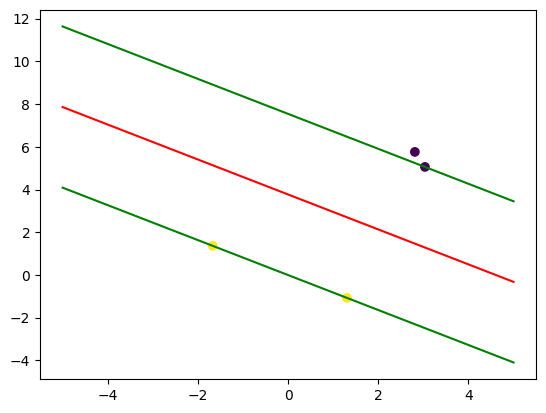

In [5]:
# Generate dataset
X, y = generate_dataset(2)

# Generate matrices
A, b, C, d, G, g = generate_matrices(X, y, 1)

# Compute alpha 
alpha = QPGenericConstraints(G, g, A, C, b, d)

# Compute hyperplane
w, b = compute_hyperplane(alpha, X, y)

# Plot points, margins and hyperplane
linespace = np.linspace(-5, 5, 100)

plt.scatter(X[0,:], X[1,:], c=y)
plt.plot(linespace, -(w[0]*linespace + b) / w[1], 'r')
plt.plot(linespace, -(w[0]*linespace + b+1) / w[1], 'g')
plt.plot(linespace, -(w[0]*linespace + b-1) / w[1], 'g')
plt.show()

nfnfod